In [24]:
#import keras essentials and stuff
import tensorflow as tf
from keras.layers import Dropout
from keras.layers import Dense
from keras import regularizers
from keras.models import Sequential

import matplotlib.pyplot as plt
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


# Making a neural net
---
the neural net takes two input variables for now 
the genre(as one bit encoded) and a historical event (i.e second world war, vietnam war, etc).

genres are one hot encoded as wel as the historical event.
this is split per columns and each genre and historical event gets it's own column.

this spits out a release year based on genre

# Preprocessing
---
preprocessing the data is necessary to make it suitable for the neural network

In [25]:
# import neccessary stuff 
#run this from the datascience-films folder
import pandas as pd 
import numpy as np
from pathlib import Path
# ignore some warnings, not pressing to fix these issues, more annoying to show these
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

RESOURCE_PATH = Path('../cleaned_data')

df = pd.read_csv(RESOURCE_PATH / 'cyclus_3_data.csv',sep=',')

In [26]:
# split genres per genre and create column per genre
unique_genres = pd.unique(df["genres"].str.split(",", expand=True).stack())
df = df.join(df.pop('genres').str.get_dummies(sep=',').astype(bool))
df = df.join(df.pop('historical_event').str.join('').str.get_dummies().astype(bool))

# fill non historical events with a year after event of 0
# and drop nan values for average rating and numVotes
df.years_after_event = df.years_after_event.fillna(0)
df = df[df['averageRating'].notna()]


In [27]:
#lastly pop our target we want
target = df[['years_after_event','numVotes','averageRating']]
target['numVotes'] = target['numVotes'].astype(np.int64)
target['averageRating'] = target['averageRating'].astype(np.float64)

In [28]:
# get numeric features and set as input
numeric_feature_names = list(unique_genres)
numeric_feature_names.append('Vietnam War')
numeric_feature_names.append('Second World War')
numeric_features = df[numeric_feature_names]
numeric_features

,Comedy,Drama,War,Romance,Short,Crime,Documentary,Action,Fantasy,Sci-Fi,...,History,Adventure,Music,(no genres listed),Musical,Reality-TV,News,Sport,Vietnam War,Second World War
0,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1660,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1662,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1663,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
from sklearn.model_selection import train_test_split



# splits the training and test data set in 65% : 35%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(numeric_features, target, test_size = 0.30, random_state=60)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(726, 27)
(726, 3)
(312, 27)
(312, 3)


# Neural net
---
this part is for initializing the neural net

In [30]:
# convert to the features to a tensor

X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)




In [31]:
class Neural_Net():

    def __init__(self):
        """
        Set up the neural net. 
        - input nodes one hot encoded: 
            - historical event 
            - genres
            
        - output node 
            - years after a major event specified to bring out the movie as float
            - average predicted rating as float
            - number of ratings as float
        """
        self.model = Sequential([
            Dense(50, input_shape=[27,], activation='relu', kernel_regularizer=regularizers.l2(0.05)),
            Dropout(0.5),
            Dense(300,  activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.5),
            Dense(400,  activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.5),
            Dense(3, activation='softplus')
        ])

        self.model.compile(
            optimizer= 'adam',
            loss='mean_squared_logarithmic_error'
            , metrics= ['accuracy', 'mean_squared_error'
                        ]
            )

    def train(self, epochs: int):
        self.history = self.model.fit(
            X_train,
            Y_train,
            epochs=epochs,
            batch_size=100,
            validation_split = 0.3,
            verbose=1
            )

    def evaluate(self):
        self.results = self.model.evaluate(X_test, Y_test, batch_size=32)
        print(f"results: {self.results}")

    
    def predict(self, input: tf.Tensor):
        predictions = self.model.predict(input)
        for prediction in predictions:
            print(f"prediction: {prediction}")


    def convert_to_input(self, list_of_inputs: list):
        tmp_df = pd.DataFrame(columns=numeric_feature_names)
        for index,sample in enumerate(list_of_inputs):
            tmp_df = tmp_df.append(pd.Series(dtype=bool), ignore_index=True)
            for col_index, _ in enumerate(tmp_df.columns):
                for genre in sample[0]:
                    tmp_df.loc[index, tmp_df.columns.values == genre] = True
                # hardcoded to check where to start filling in the second world war and vietnam labels.
                if col_index == 25:
                    for event in sample[1]:
                        tmp_df.loc[index, tmp_df.columns.values == event] = True
        tmp_df = tmp_df.fillna(False)
        return tf.convert_to_tensor(tmp_df)




    def save(self, path):
        """
        save the trained weights.
        """
        self.model.save_weights(path)
    
    def load(self, path: str):
        """
        load the weights of the model
        """
        self.model.load_weights(path)

    def plot_cost(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.plot(epochs, loss, 'bo', label='Training_loss')
        plt.plot(epochs,val_loss, 'bo', color='g', label='Val_loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    def plot_acc(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        epochs = range(1, len(loss) + 1)
        plt.figure(figsize=(16, 6))
        plt.plot(epochs, val_acc, 'y', label='Validation acc')
        plt.plot(epochs, acc, 'b', label=' acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()


model = Neural_Net()

In [38]:
#train the model
model.train(200)

Epoch 1/200
6/6 [==============================] - 0s 9ms/step - loss: 2.6618 - accuracy: 0.9331 - mean_squared_error: 2937908736.0000 - val_loss: 2.9190 - val_accuracy: 0.9541 - val_mean_squared_error: 4030023680.0000
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 2.7204 - accuracy: 0.9331 - mean_squared_error: 2937910016.0000 - val_loss: 2.9186 - val_accuracy: 0.9541 - val_mean_squared_error: 4030012160.0000
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 2.6858 - accuracy: 0.9331 - mean_squared_error: 2937872128.0000 - val_loss: 2.9154 - val_accuracy: 0.9541 - val_mean_squared_error: 4030008320.0000
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 2.6587 - accuracy: 0.9331 - mean_squared_error: 2937890048.0000 - val_loss: 2.9178 - val_accuracy: 0.9541 - val_mean_squared_error: 4029973760.0000
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 2.6839 - accuracy: 0.9331 - mean_squared_error: 29377

In [33]:
# evaluate the model
model.evaluate()


10/10 [==============================] - 0s 1ms/step - loss: 2.7558 - accuracy: 0.9583 - mean_squared_error: 497328800.0000
results: [2.755756378173828, 0.9583333134651184, 497328800.0]


In [229]:
#save the model:
model.save('checkpoints/Model_RMSLE_save_adam')

In [20]:
#load the model
model.load('checkpoints/Model_RMSLE_save_adam')

In [34]:
#predict using the model
# Note that the string should match the genre names or be left empty to set the corresponding column to False.
use_samples = [
    [['War',"Documentary"],["Vietnam War"]],
    [["War"], ["Second World War"]],
    [["Documentary"],["Vietnam War"]],
    [["Action"],[]],
    [["Documentary","War"],["Second World War"]],
    [["Sport"],["Vietnam War"]],
    [["Romance"],["Second World War"]]
    ]
new_data = model.convert_to_input(use_samples)
model.predict(new_data)

prediction: [2.1178810e-02 1.0474116e+02 6.3262424e+00]
prediction: [ 14.391143 140.08258    6.659232]
prediction: [7.2983005e-03 1.0217918e+02 6.2975402e+00]
prediction: [7.22889788e-03 1.02157326e+02 6.29744720e+00]
prediction: [ 14.377281  140.04828     6.6585383]
prediction: [7.3677055e-03 1.0221339e+02 6.2983160e+00]
prediction: [ 12.966697 137.31369    6.630463]


/tmp/ipykernel_2346/3538268545.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,val_loss, 'bo', color='g', label='Val_loss')


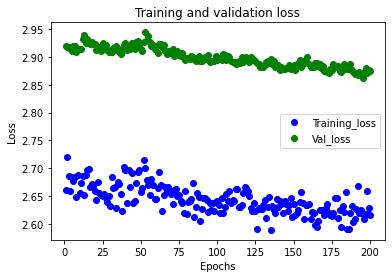

In [39]:
model.plot_cost()

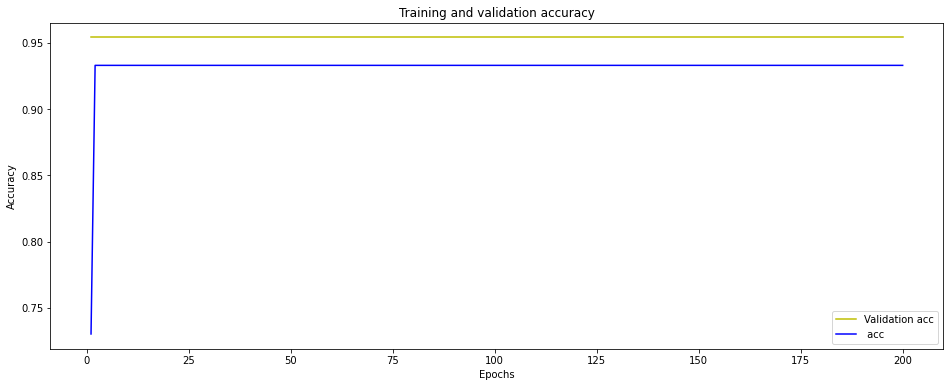

In [36]:
model.plot_acc()

# Next steps
---

whoop